# Activation stats

In [1]:
#|export
from __future__ import annotations
import random,math,torch,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from functools import partial

from miniai.datasets import *
from miniai.learner import *

In [2]:
import torch.nn.functional as F,matplotlib as mpl
from pathlib import Path
from operator import attrgetter,itemgetter
from contextlib import contextmanager

from torch import tensor,nn,optim
import torchvision.transforms.functional as TF
from datasets import load_dataset

from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
mpl.rcParams['figure.constrained_layout.use'] = True

import logging
logging.disable(logging.WARNING)

In [3]:
def set_seed(seed, deterministic=False):
    torch.use_deterministic_algorithms(deterministic)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

In [4]:
x, y = 'image', 'label'
name = 'fashion_mnist'
dsd = load_dataset(name)
bs = 1024

@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train

## Baseline

In [5]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

def cnn_layers():
    return [
        conv(1,   8, ks=5), # 14x14
        conv(8,  16),      # 7x7
        conv(16, 32),     # 4x4
        conv(32, 64),     # 2x2
        conv(64, 10, act=False),     # 1x1
        nn.Flatten()]

In [6]:
from torcheval.metrics import MulticlassAccuracy

In [7]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]

In [8]:
# NB: high learning rate to iterate quickly but high potential for blowup/ issues
def fit(model, epochs=1, xtra_cbs=None):
    learn = Learner(model, dls, loss_func=F.cross_entropy, lr=0.6, cbs=cbs+fc.L(xtra_cbs))
    learn.fit(epochs)
    return learn

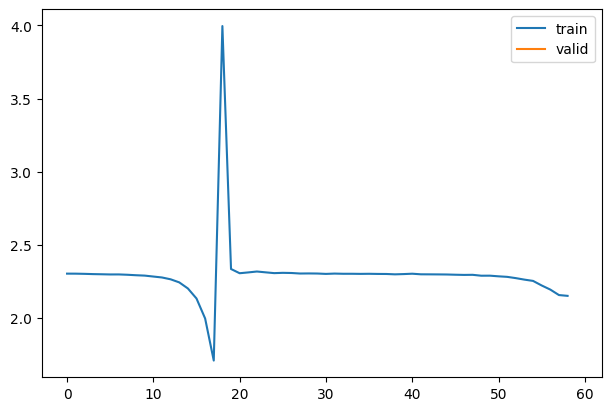

In [9]:
set_seed(1)
learn = fit(nn.Sequential(*cnn_layers()))
# learn.fit(1)

## Hooks

### Manual insertion

In [10]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds = [[] for _ in layers]
    
    def __call__(self, x):
        for i, l in enumerate(self.layers):
            x = l(x)
            x_cpu = to_cpu(x)
            self.act_means[i].append(x_cpu.mean())
            self.act_stds[i].append(x_cpu.std())
        return x
    
    def __iter__(self): return iter(self.layers)

accuracy,loss,epoch,train
0.158,2.298,0,train
0.204,2.035,0,eval


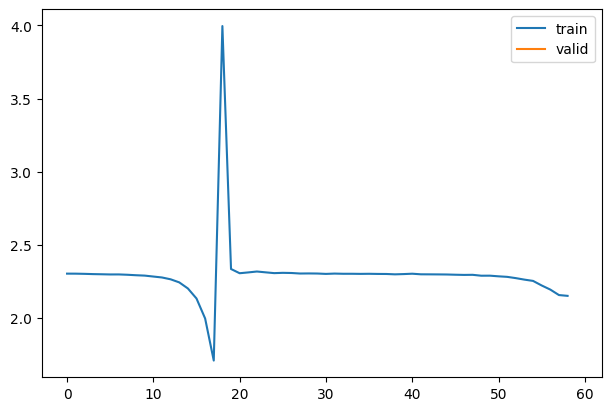

In [11]:
set_seed(1)
model = SequentialModel(*cnn_layers())
learn = fit(model)

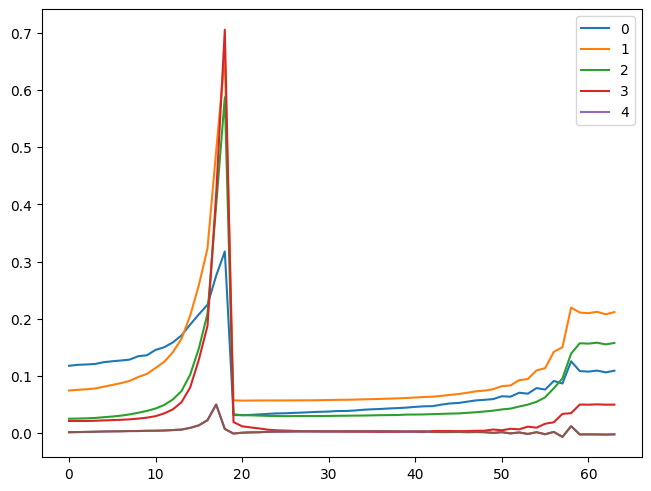

In [12]:
for l in model.act_means: plt.plot(l)
plt.legend(range(5));

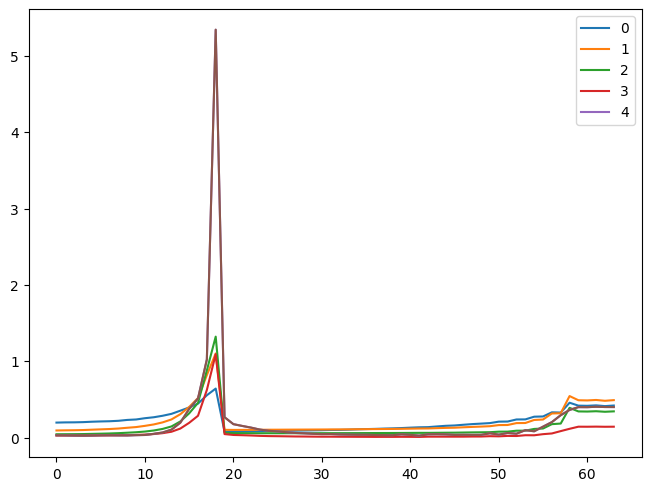

In [13]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(5));

### PyTorch hooks

Can register object to any nn.Module, called when a layer it's registered to is exceuted on forward or backward passes, depending on which hook type is registered

In [23]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

In [24]:
act_means = [[] for _ in model]
act_stds = [[] for _ in model]

In [25]:
def append_stats(i, mod, inp, outp):
    outp_cpu = to_cpu(outp)
    act_means[i].append(outp_cpu.mean())
    act_stds[i].append(outp_cpu.std())

In [26]:
for i, m in enumerate(model): m.register_forward_hook(partial(append_stats, i))

accuracy,loss,epoch,train
0.158,2.298,0,train
0.204,2.035,0,eval


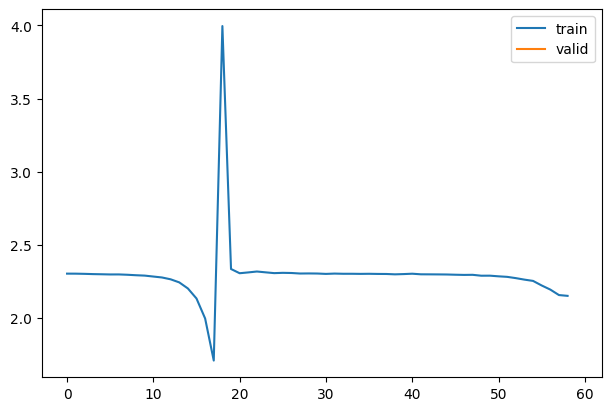

In [27]:
fit(model)

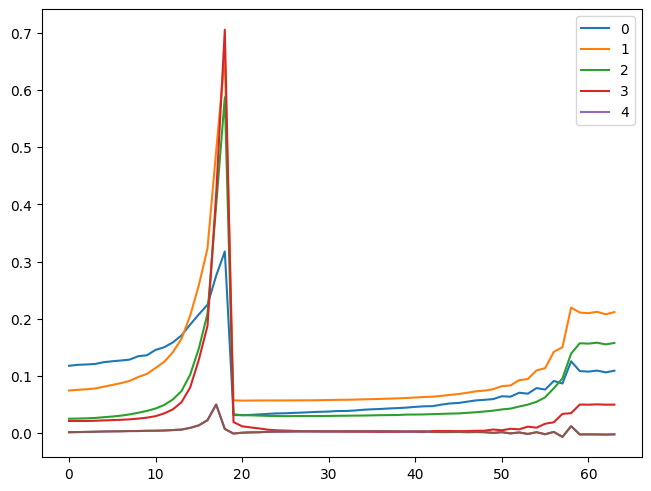

In [28]:
for o in act_means: plt.plot(o)
plt.legend(range(len(model)-1))

### Hook class

__Note__ the need to remove the hook when they're deleted, otherwise references will still exist and memory used by them will not be released when the model is deleted!

In [29]:
class Hook:
    def __init__(self, module, f): self.hook = module.register_forward_hook(partial(f, self)) 
    # def __init__(self, module, f): self.hook = module.register_forward_hook(lambda *args, **kwargs: f(self, *args, **kwargs))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()
    

In [30]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'): hook.stats = ([], [])
    acts = to_cpu(outp)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())

accuracy,loss,epoch,train
0.158,2.298,0,train
0.204,2.035,0,eval


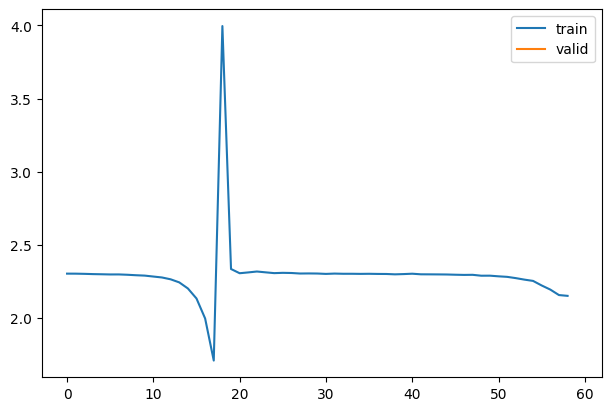

In [31]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
hooks = [Hook(m, append_stats) for m in model[:5].children()]
learn = fit(model)

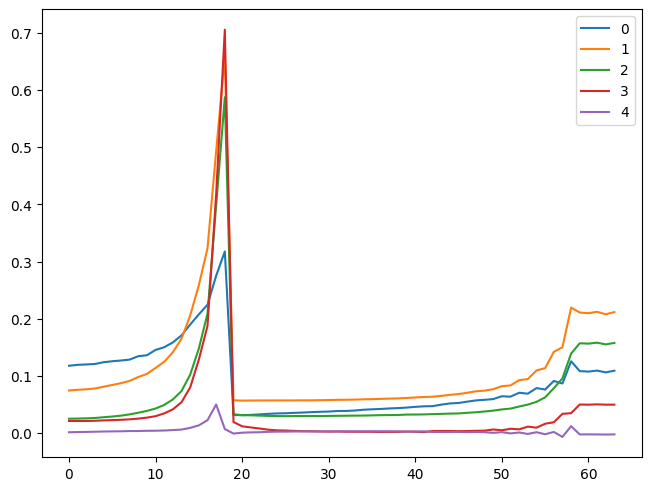

In [32]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(5));

### A Hooks class to wrap up the work on each module

Using context manager

In [33]:
class Hooks(list):
    def __init__(self, modules, f): super().__init__([Hook(m, f) for m in modules])
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.remove()
    def __del__(self): self.remove()
    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
    def remove(self):
        for h in self: h.remove()

In [34]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

accuracy,loss,epoch,train
0.158,2.298,0,train
0.204,2.035,0,eval


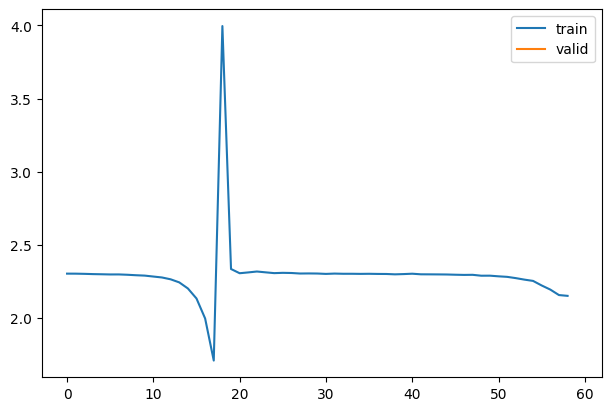

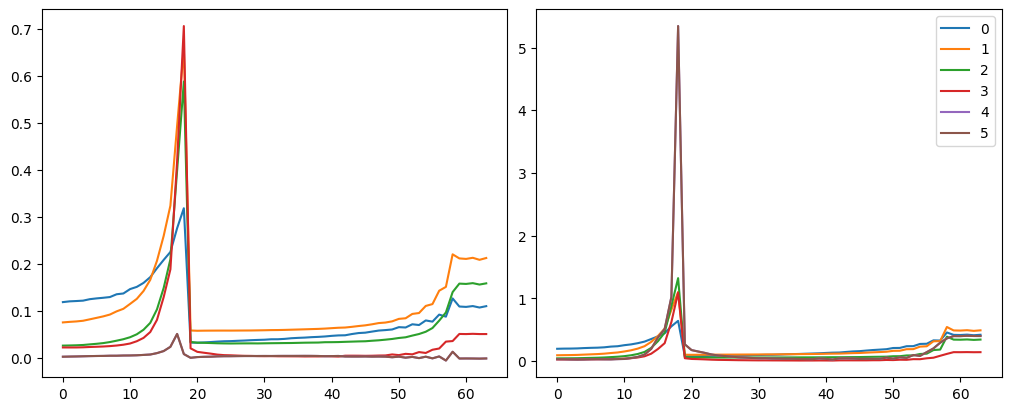

In [35]:
with Hooks(model, append_stats) as hooks:
    fit(model)
    fix, axs = plt.subplots(1, 2, figsize=(10, 4))
    for h in hooks:
        for i in (0, 1): axs[i].plot(h.stats[i])
    plt.legend(range(6));

### HooksCallback

In [36]:
class HooksCallback(Callback):
    def __init__(self, hookfunc, mod_filter=fc.noop, on_train=True, on_valid=False, mods=None):
        fc.store_attr()
        super().__init__()
    
    def before_fit(self, learn):
        if self.mods: mods = self.mods
        else: mods = fc.filter_ex(learn.model.modules(), self.mod_filter)
        self.hooks = Hooks(mods, partial(self._hookfunc, learn))

    def _hookfunc(self, learn, *args, **kwargs):
        if (self.on_train and learn.training) or (self.on_valid and not learn.training):
            self.hookfunc(*args, **kwargs)
    
    def after_fit(self, learn): self.hooks.remove()
    def __iter__(self): return iter(self.hooks)
    def __len__ (self): return len(self.hooks)    



In [37]:
hc = HooksCallback(append_stats, mod_filter=fc.risinstance(nn.Conv2d))

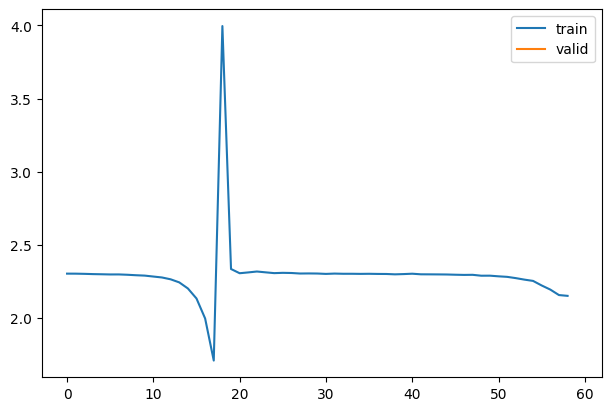

In [38]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
fit(model, xtra_cbs=[hc]);

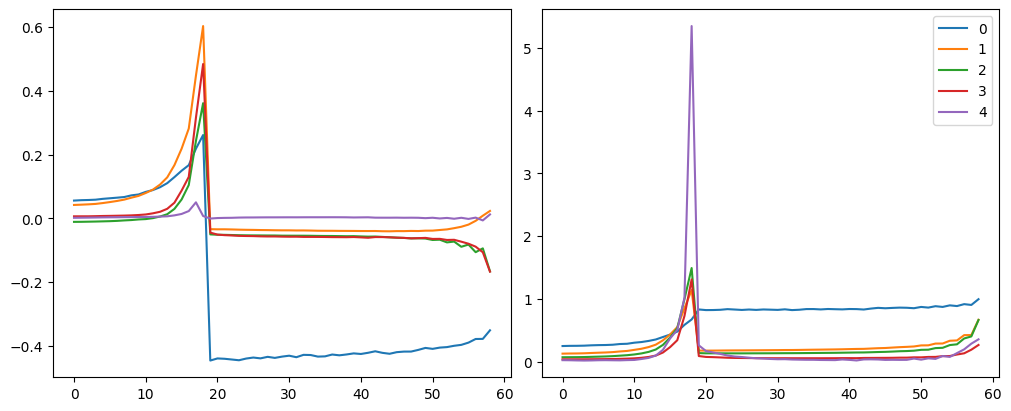

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
for h in hc:
    for i in (0, 1): axs[i].plot(h.stats[i])
plt.legend(range(6));

## Histograms

Show hist for the frequency of occuring parameter values to check for good normalisation and behaviour

In [41]:
def append_stats(hook, module, inp, outp):
    if not hasattr(hook, 'stats'): hook.stats = ([], [], [])
    acts = to_cpu(outp)
    for i, v in enumerate((acts.mean(), acts.std(), acts.abs().histc(40, 0, 10))):
        hook.stats[i].append(v)

accuracy,loss,epoch,train
0.158,2.298,0,train
0.204,2.035,0,eval


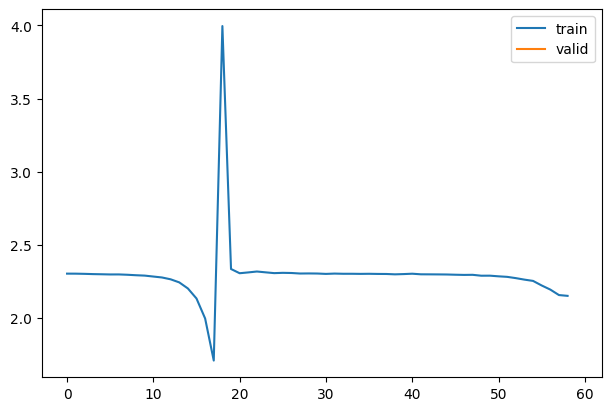

In [45]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
hc = HooksCallback(append_stats, mod_filter=fc.risinstance(nn.Conv2d))
fit(model, xtra_cbs=[hc]);

In [47]:
h0 = list(hc)[0]

In [60]:
torch.stack(h0.stats[2]).t().float().log1p().shape

torch.Size([40, 59])

In [61]:
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()

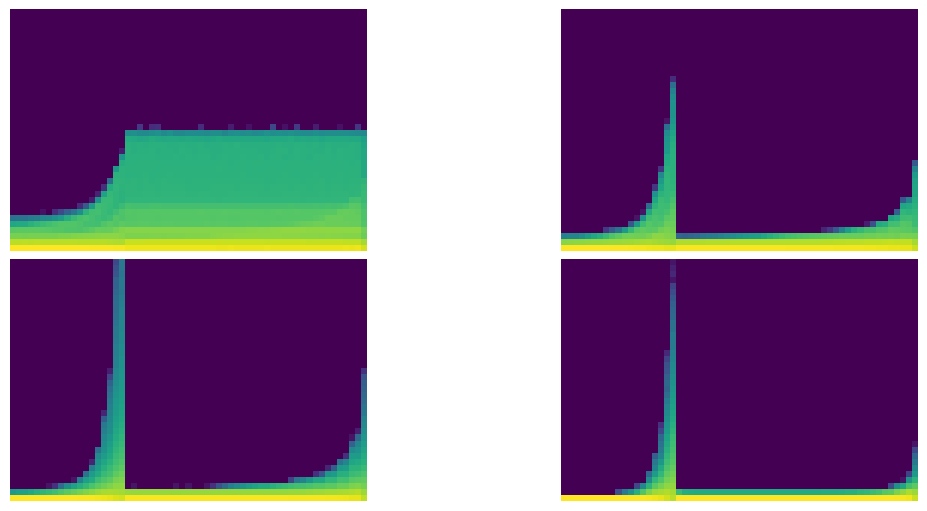

In [67]:
fig, axes = get_grid(len(hc), figsize=(11, 5))
for ax, h in zip(axes.flat, hc):
    show_image(get_hist(h), ax, origin='lower')

In [68]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[0] / h1.sum(0)

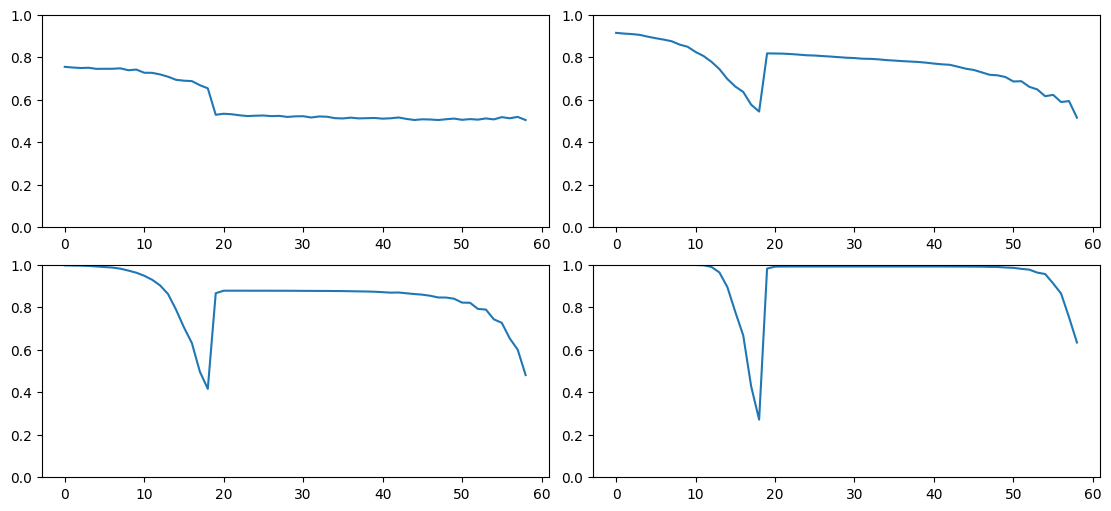

In [69]:
fig, axes = get_grid(len(hc), figsize=(11, 5))
for ax, h in zip(axes.flatten(), hc):
    ax.plot(get_min(h))
    ax.set_ylim(0, 1)


## ActivationStats

In [70]:
class ActivationStats(HooksCallback):
    def __init__(self, mod_filter=fc.noop): super().__init__(append_stats, mod_filter)
    
    def color_dim(self, figsize=(11, 5)):
        fig, axes = get_grid(len(self), figsize=figsize)
        for ax, h in zip(axes.flat, self):
            show_image(get_hist(h), ax, origin='lower')

    def dead_chart(self, figsize=(11, 5)):
        fig, axes = get_grid(len(self), figsize=figsize)
        for ax, h in zip(axes.flat, self):
            ax.plot(get_min(h))
            ax.set_ylim(0, 1)

    def plot_stats(self, figsize=(10, 4)):
        fig, axs = plt.subplots(1, 2, figsize=figsize)
        for h in self:
            for i in (0, 1):
                axs[i].plot(h.stats[i])
        axs[0].set_title('Means')
        axs[1].set_title('Stdevs')
        plt.legend(fc.L.range(self))
        

In [71]:
astats = ActivationStats(fc.risinstance(nn.Conv2d))

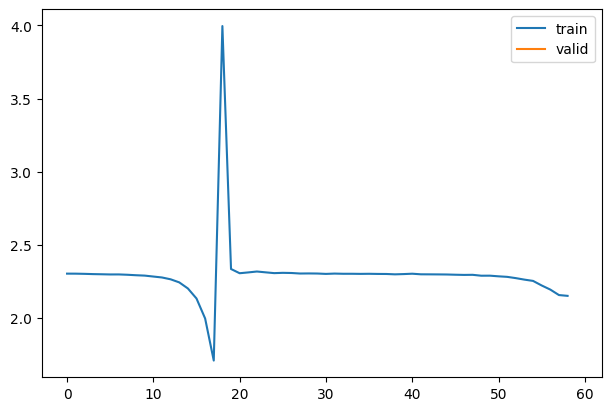

In [73]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
fit(model, xtra_cbs=[astats]);

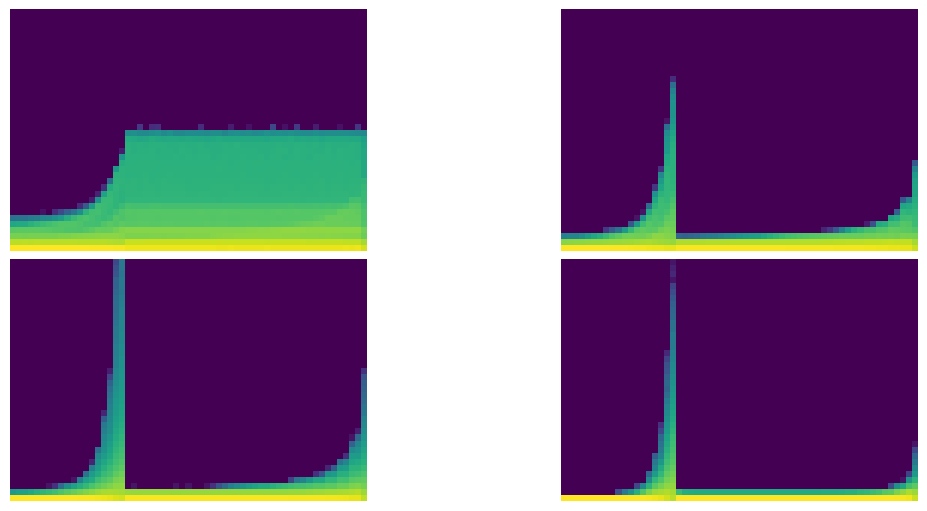

In [74]:
astats.color_dim()

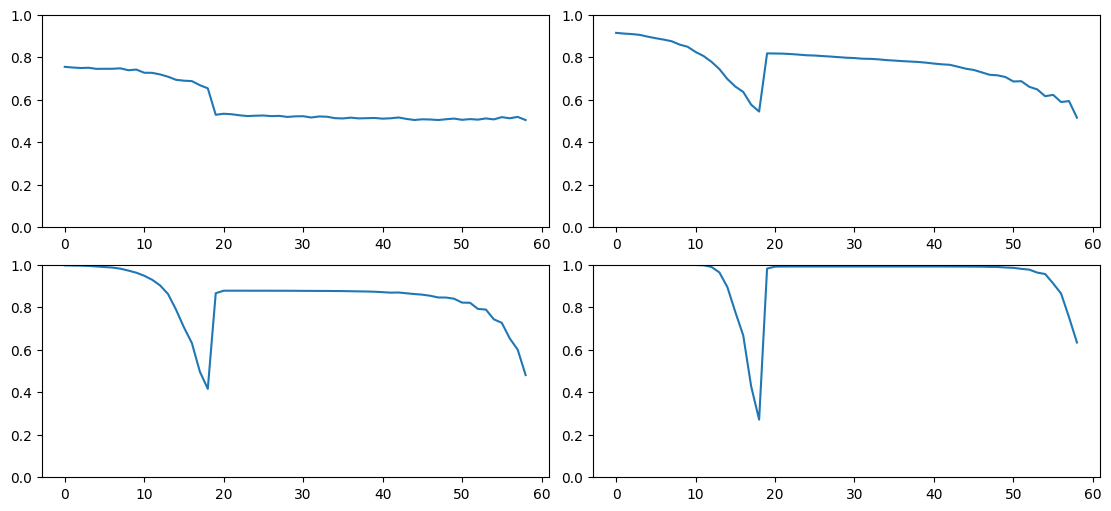

In [75]:
astats.dead_chart()

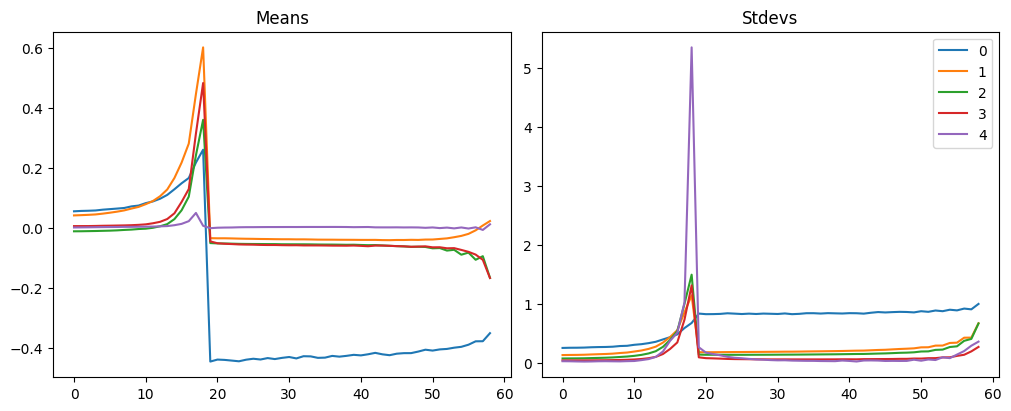

In [76]:
astats.plot_stats()